In [1]:
import math
%matplotlib inline


number_of_people = 500
width_of_grid = 30
height_of_grid = 30
number_of_iterations = 30


mu_2 = 0.1
mu_2 = math.floor(number_of_people * mu_2)


mu_3 = 0.05
mu_3 = math.floor(number_of_people * mu_3)


mu_1 = 1 - mu_2 - mu_3
mu_1 = number_of_people - mu_2 - mu_3


delta_1 = 0.1
delta_2 = 0
delta_3 = 0
delta_4 = 0


theta_12 = 0.9
theta_13 = 0.2
theta_21 = 0.3
theta_23 = 0.4
theta_34 = 0.5


sigma_12 = 0.06
sigma_13 = 0.07
sigma_21 = 0.08
sigma_23 = 0.09
sigma_34 = 0.1



print('Initial S_0: ', mu_1)
print('Initial E_0: ', mu_2)
print('Initial I_0: ', mu_3)

Initial S_0:  425
Initial E_0:  50
Initial I_0:  25


In [2]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
from mesa.batchrunner import batch_run

from itertools import cycle
import random
import math
import scipy.stats as ss

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt


stages = ['S','E','I','R']
# stages_with_death = ['S','E','I','R', 'S_delta_1', 'S_delta_2', 'S_delta_3', 'S_delta_4']


def infection_rates(model):

    agent_state = [agent.state for agent in model.schedule.agents]

    N = model.num_agents
    stages_dict = dict.fromkeys(stages, 0)


    for agents in agent_state:
        stages_dict[str(stages[agents])] += 1

    return stages_dict


def susceptible(self):
    agents = self.schedule.agents
    stages_dict = infection_rates(self)
    the_S = stages_dict['S']
    return the_S

def exposed(self):
    agents = self.schedule.agents
    stages_dict = infection_rates(self)
    the_E = stages_dict['E']
    return the_E

def infected(self):
    agents = self.schedule.agents
    stages_dict = infection_rates(self)
    the_I = stages_dict['I']
    return the_I

def recovered(self):
    agents = self.schedule.agents
    stages_dict = infection_rates(self)
    the_R = stages_dict['R']
    return the_R


class DiseaseAgent(Agent):
    def __init__(self, unique_id, model):

        super().__init__(unique_id, model)
        self.unique_id = unique_id

        global iterations
        iterations = 1
        self.model = model
        #self.iterations = iterations
        global the_time
        the_time = 1
        self.time = the_time

        self.interact_with_S = []
        self.interact_with_E = []
        self.interact_with_I = []
        self.interact_with_R = []


        s_initial = mu_s
        #s_initial = 5

        e_initial = mu_e
        #e_initial = 2

        #i_initial = 3
        i_initial = mu_i

        r_initial = int(N - e_initial - i_initial - s_initial)

        self.state = random.randint(0,2)

        stages_dict = infection_rates(model)

        if stages_dict['S'] > s_initial - 1 and self.state == 0:
            self.state = 2

            if stages_dict['I'] > i_initial - 1 and self.state == 2:
                self.state = 1

        elif stages_dict['E'] > e_initial - 1 and self.state == 1:
            self.state = 0
            if stages_dict['S'] > s_initial - 1 and self.state == 0:
                self.state = 2
        elif stages_dict['I'] > i_initial - 1 and self.state == 2:
            self.state = 0


            if stages_dict['S'] > s_initial - 1:
                self.state = 1


        else:
            self.state = self.state



    def step(self):

        #print('def step(self) of class DiseaseAgent(Agent) ')

        self.move()

        if self.state < 4:
            self.spread_disease()

        global iterations
        if (iterations % N) == 0:
            global the_time
            the_time += 1

        iterations += 1

    def spread_disease(self):


        for interaction in range(len(self.interact_with_S)):
            self.interact_with_S[interaction] += 1

        for interaction in range(len(self.interact_with_E)):
            self.interact_with_E[interaction] += 1

        for interaction in range(len(self.interact_with_I)):
            self.interact_with_I[interaction] += 1

        for interaction in range(len(self.interact_with_R)):
            self.interact_with_R[interaction] += 1


        #days: I : days
        #E's: days: (5 - 10) : to S
        # no probability
        # just probability : S becomes E
        # probability: E becomes I (after days, no need interaction)


        for agent in self.model.schedule.agents:
            the_distance = math.sqrt((self.pos[0]-agent.pos[0])**2+(self.pos[1]-agent.pos[1])**2)

            if float(the_distance) <= 5:
                if self.state == 0 and agent.state == 1:
                    self.interact_with_E.append(1)

                    for interaction in range(len(self.interact_with_E)):

                        if self.interact_with_E[interaction] == epsilon_se and self.unique_id < beta_se:
                            self.state = 1
                            self.interact_with_E = []
                            break

                elif self.state == 0 and agent.state == 2:
                    self.interact_with_I.append(1)

                    for interaction in range(len(self.interact_with_I)):
                        if self.interact_with_I[interaction] == epsilon_se and self.unique_id < beta_se:
                            self.state = 1
                            self.interact_with_I = []
                            break
                        if self.interact_with_I[interaction] == epsilon_si and self.unique_id < beta_si:
                            self.state = 2
                            self.interact_with_I = []
                            break

                elif self.state == 1:
#
                    self.interact_with_S.append(1)

                    for interaction in range(len(self.interact_with_S)):
                        if self.interact_with_S[interaction] == epsilon_es and self.unique_id < beta_es:
                            self.state = 0
                            self.interact_with_S = []
                            break


                        if self.interact_with_S[interaction] == epsilon_ei:
                            if self.unique_id < beta_ei:
                                self.state = 2
                                self.interact_with_s = []

                            break

                elif self.state == 2:

                    self.interact_with_R.append(1)

                    for interaction in range(len(self.interact_with_R)):

                        if self.interact_with_R[interaction] == epsilon_ir and self.unique_id < beta_ir:
                            self.state = 3
                            self.interact_with_R = []
                            break
                else:
                    self.state = self.state

        return





    def move(self):
   #     print('def move(self) of class DiseaseAgent(Agent) ')
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)
    #    print(possible_steps[0])
        # new_position = possible_steps[0]

        new_position = self.random.choice(possible_steps)

        self.model.grid.move_agent(self, new_position)


class DiseaseModel(Model):
    def __init__(self, n, the_width, the_height, x, y, mu_1, mu_2, mu_3, delta_1, delta_2, delta_3, delta_4, beta_12, beta_13, beta_21, beta_23, beta_34, epsilon_12, epsilon_13, epsilon_21, epsilon_23, epsilon_34, theta_12, theta_13, theta_21, theta_23, theta_34, sigma_12, sigma_13, sigma_21, sigma_23, sigma_34):
        # print('class DiseaseModel(Model) ')
        self.num_agents = n
        global N
        N = n

        global mu_e
        mu_e = mu_2
        # mu_e = math.floor(N * mu_2)


        global mu_i
        mu_i = mu_3
        # mu_i = math.floor(N * mu_3)


        global mu_s
        mu_s = mu_1
        # mu_s = N - mu_e - mu_i


        global delta_s
        delta_s = delta_1

        global delta_e
        delta_e = delta_2

        global delta_i
        delta_i = delta_3

        global delta_r
        delta_r = delta_4

        global beta_se
        beta_se = beta_12
        # beta_se = math.ceil(N * beta_12)


        global beta_si
        beta_si = beta_13
        #beta_si = math.ceil(N * beta_13)


        global beta_es
        beta_es = beta_21
        #beta_es = math.ceil(N * beta_21)


        global beta_ei
        beta_ei = beta_23
        #beta_ei = math.ceil(N * beta_23)


        global beta_ir
        beta_ir = beta_34
        #beta_ir = math.ceil(N * beta_34)


        global epsilon_se
        epsilon_se = epsilon_12

        global epsilon_si
        epsilon_si = epsilon_13

        global epsilon_es
        epsilon_es = epsilon_21

        global epsilon_ei
        epsilon_ei = epsilon_23

        global epsilon_ir
        epsilon_ir = epsilon_34

        global theta_se
        theta_se = theta_12

        global theta_si
        theta_si = theta_13

        global theta_es
        theta_es = theta_21

        global theta_ei
        theta_ei = theta_23

        global theta_ir
        theta_ir = theta_34

        global sigma_se
        sigma_se = sigma_12

        global sigma_si
        sigma_si = sigma_13

        global sigma_es
        sigma_es = sigma_21

        global sigma_ei
        sigma_ei = sigma_23

        global sigma_ir
        sigma_ir = sigma_34



        self.grid = MultiGrid(the_width, the_height, True)
        global width
        width = the_width
        global height
        height = the_height
        self.schedule = RandomActivation(self)
        self.running = True
        self.x = x
        self.y = y

        for i in range(self.num_agents):
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)

            a = DiseaseAgent(i, self)
            self.schedule.add(a)

            self.grid.place_agent(a, (x, y))

            # self.datacollector = DataCollector(model_reporters={"Current State": infection_rates},
            #    agent_reporters={"S": susceptible, "E": exposed, "I": infected, "R": recovered} )

            self.datacollector = DataCollector({"S": susceptible, "E": exposed, "I": infected, "R": recovered})







    def step(self):
    #    print('def step(self) of class DiseaseModel(Model) ')
        self.datacollector.collect(self)
        self.schedule.step()


In [3]:
# from disease_model import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib
# import plotly.express as px
import csv

from itertools import cycle
import random
import math
import scipy.stats as ss

import numpy as np
from scipy.integrate import odeint
#import matplotlib.pyplot as plt

import itertools

def looping(number_of_people, width_of_grid, height_of_grid,number_of_iterations, mu_2, mu_3, mu_1, delta_1, delta_2, delta_3, delta_4, beta_12, beta_13, beta_21, beta_23, beta_34, epsilon_12, epsilon_13, epsilon_21, epsilon_23, epsilon_34, theta_12, theta_13, theta_21, theta_23,theta_34, sigma_12, sigma_13, sigma_21, sigma_23, sigma_34 ):

#Initiating with at t_0 : S and E (no Infected at t = 0 days)
# Case 1: Infection 0 in the region at t = 0
# Case 2: Infection not 0 in the region at t = 0
# Exposed turns Infected or Susceptible after a number of days


    model = DiseaseModel(number_of_people, width_of_grid, height_of_grid, width_of_grid - 1, height_of_grid - 1,  mu_1, mu_2, mu_3, delta_1, delta_2, delta_3, delta_4, beta_12, beta_13, beta_21, beta_23, beta_34, epsilon_12, epsilon_13, epsilon_21, epsilon_23, epsilon_34, theta_12, theta_13, theta_21, theta_23, theta_34, sigma_12, sigma_13, sigma_21, sigma_23, sigma_34)
    for i in range(number_of_iterations):
        model.step()


    agent_reporters = model.datacollector.get_model_vars_dataframe()
#    print(agent_reporters)

    state_I = agent_reporters["I"]


# state_S = agent_reporters["S"]
# state_S.plot(legend='S')

# state_E = agent_reporters["E"]
# state_E.plot(legend='E')

# state_R = agent_reporters["R"]
# state_R.plot(legend='R')


# l = agent_reporters.values.tolist()
# plt.figure()
#merged = pd.DataFrame(list(itertools.chain.from_iterable(l)))
#merged.plot()


# model_reporters = model.datacollector.get_agent_vars_dataframe()
# print(model_reporters)

# # save the agent data to CSV
# agent_reporters.to_csv("agent_data.csv")

# # save the model data to CSV.
# model_reporters.to_csv("model_data.csv")
    return state_I

beta_SI:  375
beta_ES:  50
beta_EI:  350
beta_IR:  390
epsilon_SE:  4
epsilon_SI:  6
epsilon_ES:  9
epsilon_EI:  8
epsilon_IR:  12
-----------------------------
beta_SE:  45
beta_SE:  90
beta_SE:  135
beta_SE:  180
beta_SE:  225
beta_SE:  270
beta_SE:  315
beta_SE:  360
beta_SE:  405
beta_SE:  450


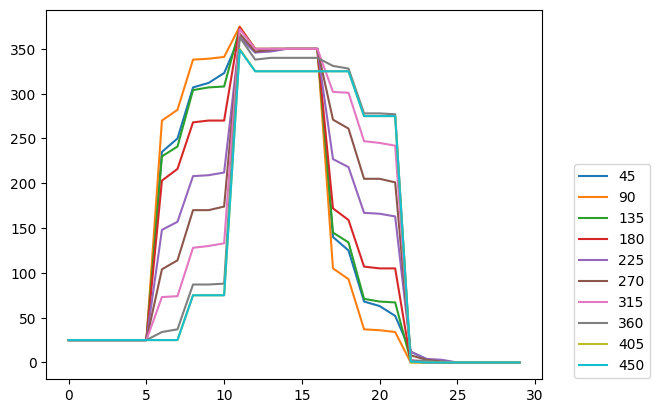

In [4]:
#beta_12 = 0.9
#beta_12 = math.ceil(number_of_people * beta_12)

beta_13 = 0.75
beta_13 = math.ceil(number_of_people * beta_13)


beta_21 = 0.1
beta_21 = math.ceil(number_of_people * beta_21)


beta_23 = 0.7
beta_23 = math.ceil(number_of_people * beta_23)


beta_34 = 0.78
beta_34 = math.ceil(number_of_people * beta_34)


epsilon_12 = 4
epsilon_13 = 6
epsilon_21 = 9
epsilon_23 = 8
epsilon_34 = 12


# %run disease_model_looping.py
lines = []


#print('beta_SE: ', beta_12)
print('beta_SI: ', beta_13)
print('beta_ES: ', beta_21)
print('beta_EI: ', beta_23)
print('beta_IR: ', beta_34)
print('epsilon_SE: ', epsilon_12)
print('epsilon_SI: ', epsilon_13)
print('epsilon_ES: ', epsilon_21)
print('epsilon_EI: ', epsilon_23)
print('epsilon_IR: ', epsilon_34)

print('-----------------------------')


for i in range(10):

    beta_12 = 0.09 * (i+1)
    beta_12 = math.ceil(number_of_people * beta_12)
    print('beta_SE: ', beta_12)


    state_I = looping(number_of_people, width_of_grid, height_of_grid,
        number_of_iterations, mu_2, mu_3, mu_1,
        delta_1, delta_2, delta_3, delta_4,
        beta_12, beta_13, beta_21, beta_23, beta_34,
        epsilon_12, epsilon_13, epsilon_21, epsilon_23, epsilon_34,
        theta_12, theta_13, theta_21, theta_23,theta_34,
        sigma_12, sigma_13, sigma_21, sigma_23, sigma_34)
    s = pd.Series(state_I)
    lines+= plt.plot(s.index, s.values,label=(str(beta_12)))

    # lines+= plt.plot(s.index, s.values,label=("I " + str("[ ") +str(beta_12) + str(", ") +str(beta_13) + str(", ")
    #                 +str(beta_21) + str(", ") +str(beta_23) + str(", ") +str(beta_34) + str(", ")
    #                 + str(epsilon_12) + str(", ") +str(epsilon_13) + str(", ") +str(epsilon_21) + str(", ")
    #                 +str(epsilon_23) + str(", ") +str(epsilon_34) + str(" ]")))


labels = [l.get_label() for l in lines]
plt.legend(lines, labels, bbox_to_anchor = (1.05, 0.6))
plt.show()


beta_SE:  450
beta_ES:  50
beta_EI:  350
beta_IR:  390
epsilon_SE:  4
epsilon_SI:  6
epsilon_ES:  9
epsilon_EI:  8
epsilon_IR:  12
-----------------------------
beta_SR:  38
beta_SR:  75
beta_SR:  113
beta_SR:  150
beta_SR:  188
beta_SR:  225
beta_SR:  263
beta_SR:  300
beta_SR:  338
beta_SR:  375


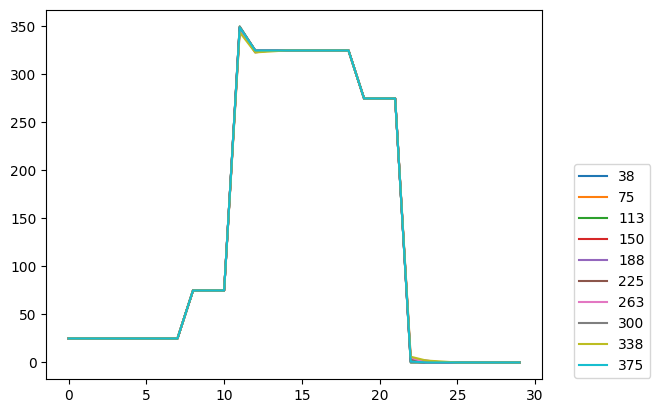

In [5]:
beta_12 = 0.9
beta_12 = math.ceil(number_of_people * beta_12)

# beta_13 = 0.75
# beta_13 = math.ceil(number_of_people * beta_13)


beta_21 = 0.1
beta_21 = math.ceil(number_of_people * beta_21)


beta_23 = 0.7
beta_23 = math.ceil(number_of_people * beta_23)


beta_34 = 0.78
beta_34 = math.ceil(number_of_people * beta_34)


epsilon_12 = 4
epsilon_13 = 6
epsilon_21 = 9
epsilon_23 = 8
epsilon_34 = 12


%run disease_model_looping.py
lines = []


print('beta_SE: ', beta_12)
# print('beta_SI: ', beta_13)
print('beta_ES: ', beta_21)
print('beta_EI: ', beta_23)
print('beta_IR: ', beta_34)
print('epsilon_SE: ', epsilon_12)
print('epsilon_SI: ', epsilon_13)
print('epsilon_ES: ', epsilon_21)
print('epsilon_EI: ', epsilon_23)
print('epsilon_IR: ', epsilon_34)

print('-----------------------------')


for i in range(10):

    beta_13 =  (0.15/2)* (i+1)
    beta_13 = math.ceil(number_of_people * beta_13)
    print('beta_SR: ', beta_13)


    state_I = looping(number_of_people, width_of_grid, height_of_grid,
        number_of_iterations, mu_2, mu_3, mu_1,
        delta_1, delta_2, delta_3, delta_4,
        beta_12, beta_13, beta_21, beta_23, beta_34,
        epsilon_12, epsilon_13, epsilon_21, epsilon_23, epsilon_34,
        theta_12, theta_13, theta_21, theta_23,theta_34,
        sigma_12, sigma_13, sigma_21, sigma_23, sigma_34)
    s = pd.Series(state_I)
    lines+= plt.plot(s.index, s.values,label=(str(beta_13)))

    # lines+= plt.plot(s.index, s.values,label=("I " + str("[ ") +str(beta_12) + str(", ") +str(beta_13) + str(", ")
    #                 +str(beta_21) + str(", ") +str(beta_23) + str(", ") +str(beta_34) + str(", ")
    #                 + str(epsilon_12) + str(", ") +str(epsilon_13) + str(", ") +str(epsilon_21) + str(", ")
    #                 +str(epsilon_23) + str(", ") +str(epsilon_34) + str(" ]")))


labels = [l.get_label() for l in lines]
plt.legend(lines, labels, bbox_to_anchor = (1.05, 0.6))
plt.show()


beta_SE:  450
beta_SI:  375
beta_EI:  350
beta_IR:  390
epsilon_SE:  4
epsilon_SI:  6
epsilon_ES:  9
epsilon_EI:  8
epsilon_IR:  12
-----------------------------
beta_ES:  10
beta_ES:  20
beta_ES:  30
beta_ES:  40
beta_ES:  50


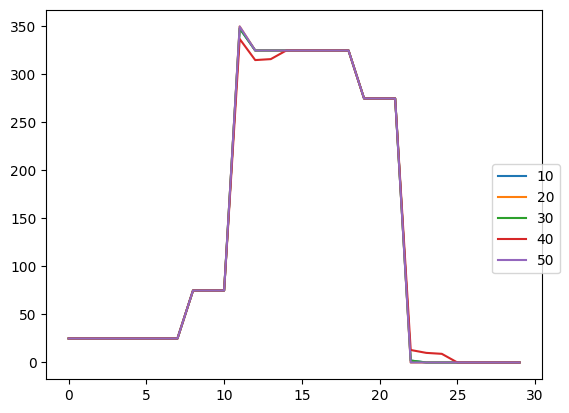

In [6]:
beta_12 = 0.9
beta_12 = math.ceil(number_of_people * beta_12)

beta_13 = 0.75
beta_13 = math.ceil(number_of_people * beta_13)


# beta_21 = 0.1
# beta_21 = math.ceil(number_of_people * beta_21)


beta_23 = 0.7
beta_23 = math.ceil(number_of_people * beta_23)


beta_34 = 0.78
beta_34 = math.ceil(number_of_people * beta_34)


epsilon_12 = 4
epsilon_13 = 6
epsilon_21 = 9
epsilon_23 = 8
epsilon_34 = 12




%run disease_model_looping.py
lines = []


print('beta_SE: ', beta_12)
print('beta_SI: ', beta_13)
# print('beta_ES: ', beta_21)
print('beta_EI: ', beta_23)
print('beta_IR: ', beta_34)
print('epsilon_SE: ', epsilon_12)
print('epsilon_SI: ', epsilon_13)
print('epsilon_ES: ', epsilon_21)
print('epsilon_EI: ', epsilon_23)
print('epsilon_IR: ', epsilon_34)

print('-----------------------------')


for i in range(5):

    beta_21 = 0.02 * (i+1)
    beta_21 = math.ceil(number_of_people * beta_21)
    print('beta_ES: ', beta_21)


    state_I = looping(number_of_people, width_of_grid, height_of_grid,
        number_of_iterations, mu_2, mu_3, mu_1,
        delta_1, delta_2, delta_3, delta_4,
        beta_12, beta_13, beta_21, beta_23, beta_34,
        epsilon_12, epsilon_13, epsilon_21, epsilon_23, epsilon_34,
        theta_12, theta_13, theta_21, theta_23,theta_34,
        sigma_12, sigma_13, sigma_21, sigma_23, sigma_34)
    s = pd.Series(state_I)
    lines+= plt.plot(s.index, s.values,label=(str(beta_21)))

    # lines+= plt.plot(s.index, s.values,label=("I " + str("[ ") +str(beta_12) + str(", ") +str(beta_13) + str(", ")
    #                 +str(beta_21) + str(", ") +str(beta_23) + str(", ") +str(beta_34) + str(", ")
    #                 + str(epsilon_12) + str(", ") +str(epsilon_13) + str(", ") +str(epsilon_21) + str(", ")
    #                 +str(epsilon_23) + str(", ") +str(epsilon_34) + str(" ]")))


labels = [l.get_label() for l in lines]
plt.legend(lines, labels, bbox_to_anchor = (1.05, 0.6))
plt.show()


beta_SE:  450
beta_SI:  375
beta_ES:  50
beta_IR:  390
epsilon_SE:  4
epsilon_SI:  6
epsilon_ES:  9
epsilon_EI:  8
epsilon_IR:  12
-----------------------------
beta_EI:  70
beta_EI:  140
beta_EI:  211
beta_EI:  280
beta_EI:  351


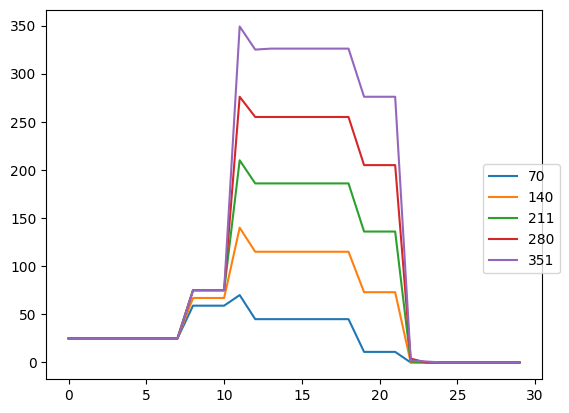

In [7]:
beta_12 = 0.9
beta_12 = math.ceil(number_of_people * beta_12)

beta_13 = 0.75
beta_13 = math.ceil(number_of_people * beta_13)


beta_21 = 0.1
beta_21 = math.ceil(number_of_people * beta_21)


# beta_23 = 0.7
# beta_23 = math.ceil(number_of_people * beta_23)


beta_34 = 0.78
beta_34 = math.ceil(number_of_people * beta_34)


epsilon_12 = 4
epsilon_13 = 6
epsilon_21 = 9
epsilon_23 = 8
epsilon_34 = 12


%run disease_model_looping.py
lines = []


print('beta_SE: ', beta_12)
print('beta_SI: ', beta_13)
print('beta_ES: ', beta_21)
# print('beta_EI: ', beta_23)
print('beta_IR: ', beta_34)
print('epsilon_SE: ', epsilon_12)
print('epsilon_SI: ', epsilon_13)
print('epsilon_ES: ', epsilon_21)
print('epsilon_EI: ', epsilon_23)
print('epsilon_IR: ', epsilon_34)

print('-----------------------------')


for i in range(5):

    beta_23 = 0.14 * (i+1)
    beta_23 = math.ceil(number_of_people * beta_23)
    print('beta_EI: ', beta_23)


    state_I = looping(number_of_people, width_of_grid, height_of_grid,
        number_of_iterations, mu_2, mu_3, mu_1,
        delta_1, delta_2, delta_3, delta_4,
        beta_12, beta_13, beta_21, beta_23, beta_34,
        epsilon_12, epsilon_13, epsilon_21, epsilon_23, epsilon_34,
        theta_12, theta_13, theta_21, theta_23,theta_34,
        sigma_12, sigma_13, sigma_21, sigma_23, sigma_34)
    s = pd.Series(state_I)
    lines+= plt.plot(s.index, s.values,label=(str(beta_23)))

    # lines+= plt.plot(s.index, s.values,label=("I " + str("[ ") +str(beta_12) + str(", ") +str(beta_13) + str(", ")
    #                 +str(beta_21) + str(", ") +str(beta_23) + str(", ") +str(beta_34) + str(", ")
    #                 + str(epsilon_12) + str(", ") +str(epsilon_13) + str(", ") +str(epsilon_21) + str(", ")
    #                 +str(epsilon_23) + str(", ") +str(epsilon_34) + str(" ]")))


labels = [l.get_label() for l in lines]
plt.legend(lines, labels, bbox_to_anchor = (1.05, 0.6))
plt.show()


beta_SE:  450
beta_SI:  375
beta_ES:  50
beta_EI:  350
epsilon_SE:  4
epsilon_SI:  6
epsilon_ES:  9
epsilon_EI:  8
epsilon_IR:  12
-----------------------------
beta_IR:  78
beta_IR:  156
beta_IR:  234
beta_IR:  312
beta_IR:  390


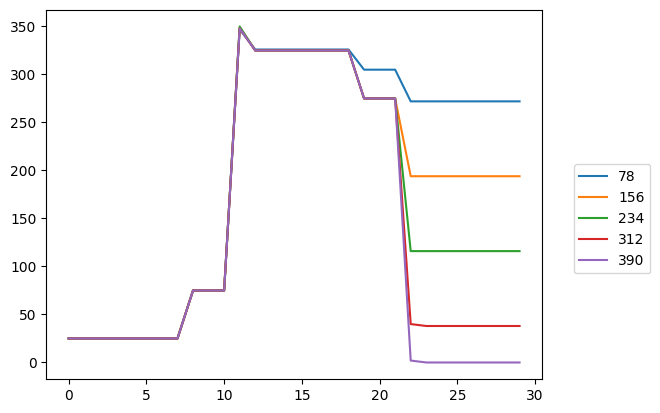

In [8]:
beta_12 = 0.9
beta_12 = math.ceil(number_of_people * beta_12)

beta_13 = 0.75
beta_13 = math.ceil(number_of_people * beta_13)


beta_21 = 0.1
beta_21 = math.ceil(number_of_people * beta_21)


beta_23 = 0.7
beta_23 = math.ceil(number_of_people * beta_23)


# beta_34 = 0.78
# beta_34 = math.ceil(number_of_people * beta_34)


epsilon_12 = 4
epsilon_13 = 6
epsilon_21 = 9
epsilon_23 = 8
epsilon_34 = 12



%run disease_model_looping.py
lines = []


print('beta_SE: ', beta_12)
print('beta_SI: ', beta_13)
print('beta_ES: ', beta_21)
print('beta_EI: ', beta_23)
# print('beta_IR: ', beta_34)
print('epsilon_SE: ', epsilon_12)
print('epsilon_SI: ', epsilon_13)
print('epsilon_ES: ', epsilon_21)
print('epsilon_EI: ', epsilon_23)
print('epsilon_IR: ', epsilon_34)

print('-----------------------------')


for i in range(5):

    beta_34 = 0.156 * (i+1)
    beta_34 = math.ceil(number_of_people * beta_34)
    print('beta_IR: ', beta_34)


    state_I = looping(number_of_people, width_of_grid, height_of_grid,
        number_of_iterations, mu_2, mu_3, mu_1,
        delta_1, delta_2, delta_3, delta_4,
        beta_12, beta_13, beta_21, beta_23, beta_34,
        epsilon_12, epsilon_13, epsilon_21, epsilon_23, epsilon_34,
        theta_12, theta_13, theta_21, theta_23,theta_34,
        sigma_12, sigma_13, sigma_21, sigma_23, sigma_34)
    s = pd.Series(state_I)
    lines+= plt.plot(s.index, s.values,label=(str(beta_34)))

    # lines+= plt.plot(s.index, s.values,label=("I " + str("[ ") +str(beta_12) + str(", ") +str(beta_13) + str(", ")
    #                 +str(beta_21) + str(", ") +str(beta_23) + str(", ") +str(beta_34) + str(", ")
    #                 + str(epsilon_12) + str(", ") +str(epsilon_13) + str(", ") +str(epsilon_21) + str(", ")
    #                 +str(epsilon_23) + str(", ") +str(epsilon_34) + str(" ]")))


labels = [l.get_label() for l in lines]
plt.legend(lines, labels, bbox_to_anchor = (1.05, 0.6))
plt.show()


beta_SE:  450
beta_SI:  375
beta_ES:  50
beta_EI:  350
beta_IR:  390
epsilon_SI:  6
epsilon_ES:  9
epsilon_EI:  8
epsilon_IR:  12
-----------------------------
epsilon_SE:  2
epsilon_SE:  3
epsilon_SE:  4
epsilon_SE:  5
epsilon_SE:  6


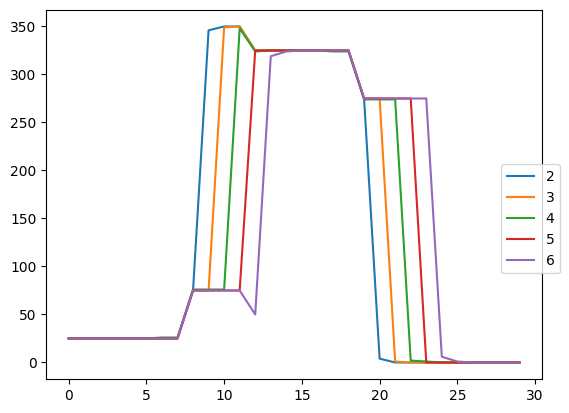

In [9]:
beta_12 = 0.9
beta_12 = math.ceil(number_of_people * beta_12)

beta_13 = 0.75
beta_13 = math.ceil(number_of_people * beta_13)


beta_21 = 0.1
beta_21 = math.ceil(number_of_people * beta_21)


beta_23 = 0.7
beta_23 = math.ceil(number_of_people * beta_23)


beta_34 = 0.78
beta_34 = math.ceil(number_of_people * beta_34)


# epsilon_12 = 4
epsilon_13 = 6
epsilon_21 = 9
epsilon_23 = 8
epsilon_34 = 12



%run disease_model_looping.py
lines = []


print('beta_SE: ', beta_12)
print('beta_SI: ', beta_13)
print('beta_ES: ', beta_21)
print('beta_EI: ', beta_23)
print('beta_IR: ', beta_34)

#print('epsilon_SE: ', epsilon_12)
print('epsilon_SI: ', epsilon_13)
print('epsilon_ES: ', epsilon_21)
print('epsilon_EI: ', epsilon_23)
print('epsilon_IR: ', epsilon_34)


print('-----------------------------')


for i in range(5):

    epsilon_12 = 2 + i
    print('epsilon_SE: ', epsilon_12)


    state_I = looping(number_of_people, width_of_grid, height_of_grid,
        number_of_iterations, mu_2, mu_3, mu_1,
        delta_1, delta_2, delta_3, delta_4,
        beta_12, beta_13, beta_21, beta_23, beta_34,
        epsilon_12, epsilon_13, epsilon_21, epsilon_23, epsilon_34,
        theta_12, theta_13, theta_21, theta_23,theta_34,
        sigma_12, sigma_13, sigma_21, sigma_23, sigma_34)
    s = pd.Series(state_I)
    lines+= plt.plot(s.index, s.values,label=(str(epsilon_12)))

    # lines+= plt.plot(s.index, s.values,label=("I " + str("[ ") +str(beta_12) + str(", ") +str(beta_13) + str(", ")
    #                 +str(beta_21) + str(", ") +str(beta_23) + str(", ") +str(beta_34) + str(", ")
    #                 + str(epsilon_12) + str(", ") +str(epsilon_13) + str(", ") +str(epsilon_21) + str(", ")
    #                 +str(epsilon_23) + str(", ") +str(epsilon_34) + str(" ]")))


labels = [l.get_label() for l in lines]
plt.legend(lines, labels, bbox_to_anchor = (1.05, 0.6))
plt.show()


beta_SE:  450
beta_SI:  375
beta_ES:  50
beta_EI:  350
beta_IR:  390
epsilon_SE:  4
epsilon_ES:  9
epsilon_EI:  8
epsilon_IR:  12
-----------------------------
epsilon_SI:  3
epsilon_SI:  4
epsilon_SI:  5
epsilon_SI:  6
epsilon_SI:  7


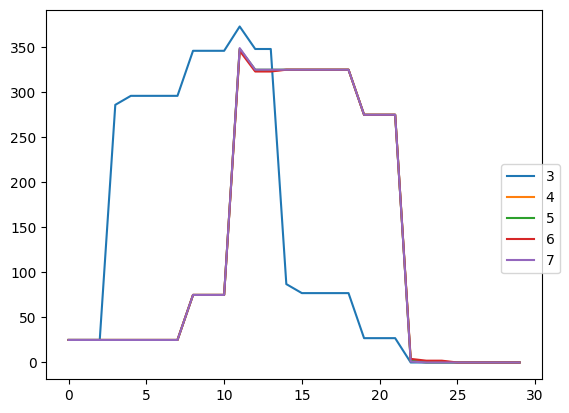

In [10]:
beta_12 = 0.9
beta_12 = math.ceil(number_of_people * beta_12)

beta_13 = 0.75
beta_13 = math.ceil(number_of_people * beta_13)


beta_21 = 0.1
beta_21 = math.ceil(number_of_people * beta_21)


beta_23 = 0.7
beta_23 = math.ceil(number_of_people * beta_23)


beta_34 = 0.78
beta_34 = math.ceil(number_of_people * beta_34)


epsilon_12 = 4
# epsilon_13 = 6
epsilon_21 = 9
epsilon_23 = 8
epsilon_34 = 12


%run disease_model_looping.py
lines = []


print('beta_SE: ', beta_12)
print('beta_SI: ', beta_13)
print('beta_ES: ', beta_21)
print('beta_EI: ', beta_23)
print('beta_IR: ', beta_34)
print('epsilon_SE: ', epsilon_12)
#print('epsilon_SI: ', epsilon_13)
print('epsilon_ES: ', epsilon_21)
print('epsilon_EI: ', epsilon_23)
print('epsilon_IR: ', epsilon_34)


print('-----------------------------')


for i in range(5):

    epsilon_13 = 3 + i
    print('epsilon_SI: ', epsilon_13)


    state_I = looping(number_of_people, width_of_grid, height_of_grid,
        number_of_iterations, mu_2, mu_3, mu_1,
        delta_1, delta_2, delta_3, delta_4,
        beta_12, beta_13, beta_21, beta_23, beta_34,
        epsilon_12, epsilon_13, epsilon_21, epsilon_23, epsilon_34,
        theta_12, theta_13, theta_21, theta_23,theta_34,
        sigma_12, sigma_13, sigma_21, sigma_23, sigma_34)
    s = pd.Series(state_I)
    lines+= plt.plot(s.index, s.values,label=(str(epsilon_13)))

    # lines+= plt.plot(s.index, s.values,label=("I " + str("[ ") +str(beta_12) + str(", ") +str(beta_13) + str(", ")
    #                 +str(beta_21) + str(", ") +str(beta_23) + str(", ") +str(beta_34) + str(", ")
    #                 + str(epsilon_12) + str(", ") +str(epsilon_13) + str(", ") +str(epsilon_21) + str(", ")
    #                 +str(epsilon_23) + str(", ") +str(epsilon_34) + str(" ]")))


labels = [l.get_label() for l in lines]
plt.legend(lines, labels, bbox_to_anchor = (1.05, 0.6))
plt.show()


beta_SE:  450
beta_SI:  375
beta_ES:  50
beta_EI:  350
beta_IR:  390
epsilon_SE:  4
epsilon_SI:  6
epsilon_EI:  8
epsilon_IR:  12
-----------------------------
epsilon_ES:  6
epsilon_ES:  7
epsilon_ES:  8
epsilon_ES:  9
epsilon_ES:  10


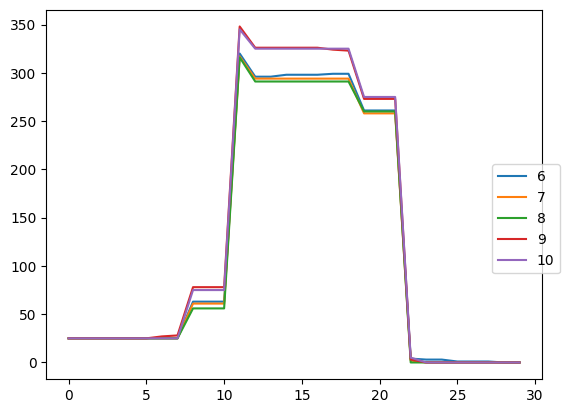

In [11]:
beta_12 = 0.9
beta_12 = math.ceil(number_of_people * beta_12)

beta_13 = 0.75
beta_13 = math.ceil(number_of_people * beta_13)


beta_21 = 0.1
beta_21 = math.ceil(number_of_people * beta_21)


beta_23 = 0.7
beta_23 = math.ceil(number_of_people * beta_23)


beta_34 = 0.78
beta_34 = math.ceil(number_of_people * beta_34)


epsilon_12 = 4
epsilon_13 = 6
# epsilon_21 = 9
epsilon_23 = 8
epsilon_34 = 12


%run disease_model_looping.py
lines = []


print('beta_SE: ', beta_12)
print('beta_SI: ', beta_13)
print('beta_ES: ', beta_21)
print('beta_EI: ', beta_23)
print('beta_IR: ', beta_34)
print('epsilon_SE: ', epsilon_12)
print('epsilon_SI: ', epsilon_13)
#print('epsilon_ES: ', epsilon_21)
print('epsilon_EI: ', epsilon_23)
print('epsilon_IR: ', epsilon_34)


print('-----------------------------')


for i in range(5):

    epsilon_21 = 6 + i
    print('epsilon_ES: ', epsilon_21)


    state_I = looping(number_of_people, width_of_grid, height_of_grid,
        number_of_iterations, mu_2, mu_3, mu_1,
        delta_1, delta_2, delta_3, delta_4,
        beta_12, beta_13, beta_21, beta_23, beta_34,
        epsilon_12, epsilon_13, epsilon_21, epsilon_23, epsilon_34,
        theta_12, theta_13, theta_21, theta_23,theta_34,
        sigma_12, sigma_13, sigma_21, sigma_23, sigma_34)
    s = pd.Series(state_I)
    lines+= plt.plot(s.index, s.values,label=(str(epsilon_21)))

    # lines+= plt.plot(s.index, s.values,label=("I " + str("[ ") +str(beta_12) + str(", ") +str(beta_13) + str(", ")
    #                 +str(beta_21) + str(", ") +str(beta_23) + str(", ") +str(beta_34) + str(", ")
    #                 + str(epsilon_12) + str(", ") +str(epsilon_13) + str(", ") +str(epsilon_21) + str(", ")
    #                 +str(epsilon_23) + str(", ") +str(epsilon_34) + str(" ]")))


labels = [l.get_label() for l in lines]
plt.legend(lines, labels, bbox_to_anchor = (1.05, 0.6))
plt.show()


beta_SE:  450
beta_SI:  375
beta_ES:  50
beta_EI:  350
beta_IR:  390
epsilon_SE:  4
epsilon_SI:  6
epsilon_ES:  9
epsilon_IR:  12
-----------------------------
epsilon_EI:  5
epsilon_EI:  6
epsilon_EI:  7
epsilon_EI:  8
epsilon_EI:  9


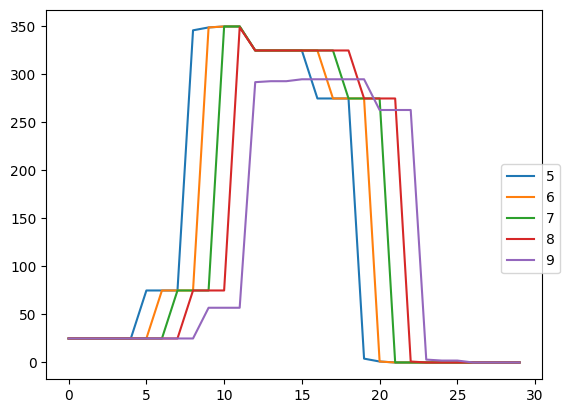

In [12]:
beta_12 = 0.9
beta_12 = math.ceil(number_of_people * beta_12)

beta_13 = 0.75
beta_13 = math.ceil(number_of_people * beta_13)


beta_21 = 0.1
beta_21 = math.ceil(number_of_people * beta_21)


beta_23 = 0.7
beta_23 = math.ceil(number_of_people * beta_23)


beta_34 = 0.78
beta_34 = math.ceil(number_of_people * beta_34)


epsilon_12 = 4
epsilon_13 = 6
epsilon_21 = 9
# epsilon_23 = 8
epsilon_34 = 12


%run disease_model_looping.py
lines = []


print('beta_SE: ', beta_12)
print('beta_SI: ', beta_13)
print('beta_ES: ', beta_21)
print('beta_EI: ', beta_23)
print('beta_IR: ', beta_34)
print('epsilon_SE: ', epsilon_12)
print('epsilon_SI: ', epsilon_13)
print('epsilon_ES: ', epsilon_21)
#print('epsilon_EI: ', epsilon_23)
print('epsilon_IR: ', epsilon_34)


print('-----------------------------')


for i in range(5):

    epsilon_23 = 5 + i
    print('epsilon_EI: ', epsilon_23)


    state_I = looping(number_of_people, width_of_grid, height_of_grid,
        number_of_iterations, mu_2, mu_3, mu_1,
        delta_1, delta_2, delta_3, delta_4,
        beta_12, beta_13, beta_21, beta_23, beta_34,
        epsilon_12, epsilon_13, epsilon_21, epsilon_23, epsilon_34,
        theta_12, theta_13, theta_21, theta_23,theta_34,
        sigma_12, sigma_13, sigma_21, sigma_23, sigma_34)
    s = pd.Series(state_I)
    lines+= plt.plot(s.index, s.values,label=(str(epsilon_23)))

    # lines+= plt.plot(s.index, s.values,label=("I " + str("[ ") +str(beta_12) + str(", ") +str(beta_13) + str(", ")
    #                 +str(beta_21) + str(", ") +str(beta_23) + str(", ") +str(beta_34) + str(", ")
    #                 + str(epsilon_12) + str(", ") +str(epsilon_13) + str(", ") +str(epsilon_21) + str(", ")
    #                 +str(epsilon_23) + str(", ") +str(epsilon_34) + str(" ]")))


labels = [l.get_label() for l in lines]
plt.legend(lines, labels, bbox_to_anchor = (1.05, 0.6))
plt.show()


beta_SE:  450
beta_SI:  375
beta_ES:  50
beta_EI:  350
beta_IR:  390
epsilon_SE:  4
epsilon_SI:  6
epsilon_ES:  9
epsilon_EI:  8
-----------------------------
epsilon_IR:  3
epsilon_IR:  4
epsilon_IR:  5
epsilon_IR:  6
epsilon_IR:  7
epsilon_IR:  8
epsilon_IR:  9
epsilon_IR:  10
epsilon_IR:  11
epsilon_IR:  12


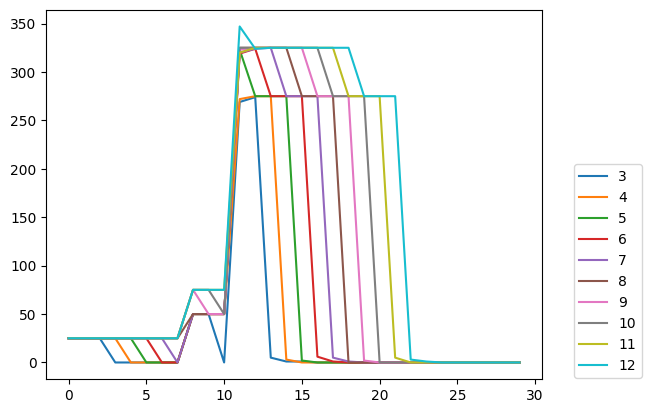

In [13]:
beta_12 = 0.9
beta_12 = math.ceil(number_of_people * beta_12)

beta_13 = 0.75
beta_13 = math.ceil(number_of_people * beta_13)


beta_21 = 0.1
beta_21 = math.ceil(number_of_people * beta_21)


beta_23 = 0.7
beta_23 = math.ceil(number_of_people * beta_23)


beta_34 = 0.78
beta_34 = math.ceil(number_of_people * beta_34)


epsilon_12 = 4
epsilon_13 = 6
epsilon_21 = 9
epsilon_23 = 8
# epsilon_34 = 12


# %run disease_model_looping.py
lines = []


print('beta_SE: ', beta_12)
print('beta_SI: ', beta_13)
print('beta_ES: ', beta_21)
print('beta_EI: ', beta_23)
print('beta_IR: ', beta_34)
print('epsilon_SE: ', epsilon_12)
print('epsilon_SI: ', epsilon_13)
print('epsilon_ES: ', epsilon_21)
print('epsilon_EI: ', epsilon_23)
#print('epsilon_IR: ', epsilon_34)


print('-----------------------------')


for i in range(10):

    epsilon_34 = 3 + i
    print('epsilon_IR: ', epsilon_34)


    state_I = looping(number_of_people, width_of_grid, height_of_grid,
        number_of_iterations, mu_2, mu_3, mu_1,
        delta_1, delta_2, delta_3, delta_4,
        beta_12, beta_13, beta_21, beta_23, beta_34,
        epsilon_12, epsilon_13, epsilon_21, epsilon_23, epsilon_34,
        theta_12, theta_13, theta_21, theta_23,theta_34,
        sigma_12, sigma_13, sigma_21, sigma_23, sigma_34)
    s = pd.Series(state_I)
    lines+= plt.plot(s.index, s.values,label=(str(epsilon_34)))

    # lines+= plt.plot(s.index, s.values,label=("I " + str("[ ") +str(beta_12) + str(", ") +str(beta_13) + str(", ")
    #                 +str(beta_21) + str(", ") +str(beta_23) + str(", ") +str(beta_34) + str(", ")
    #                 + str(epsilon_12) + str(", ") +str(epsilon_13) + str(", ") +str(epsilon_21) + str(", ")
    #                 +str(epsilon_23) + str(", ") +str(epsilon_34) + str(" ]")))


labels = [l.get_label() for l in lines]
plt.legend(lines, labels, bbox_to_anchor = (1.05, 0.6))
plt.show()
